In [1]:
import numpy as np
import matplotlib.pyplot as plt

from ensemblecalibration.calibration.experiments import experiment_h0

from ensemblecalibration.calibration.config import config_p_value_analysis
from ensemblecalibration.calibration.p_value_analysis import _simulation_pvals, npbe_test_p_values, npbe_test_v3_p_values
from ensemblecalibration.calibration.calibration_estimates import skceuq

### Analysis of the distribution of test statistics
sample randomly predictors from the convex hull, then perform statisstical boostrapping test. Compare value
of test statistc (miscalibration estimate) for the bootstrappping samples (wherer labels are generated under
the null hypothesis) with the value for the dataset.

In [2]:
N_FEATURES = 100
N_ENS = 10
N_CLASSES = 10
U_DIR = 0.01

In [3]:
config_p_value_analysis["SKCEul"]["params"]

{'n_predictors': 100,
 'l_prior': 1,
 'optim': 'cobyla',
 'n_resamples': 1000,
 'dist': <function ensemblecalibration.calibration.calibration_estimates.distances.tv_distance(p: numpy.ndarray, q: numpy.ndarray)>,
 'sigma': 2.0,
 'test': <function ensemblecalibration.calibration.calibration_estimates.skce.skceul(P, y, params, square_out: bool = False)>,
 'obj': <function ensemblecalibration.calibration.calibration_estimates.skce.skce_ul_obj(p_bar: numpy.ndarray, y: numpy.ndarray, params: dict)>,
 'sampling': 'lambda',
 'transform': 'isometric',
 'x_dependency': False}

test for SKCEul: 

In [4]:
p_probs, y_labels = experiment_h0(N=N_FEATURES, M=N_ENS, K=N_CLASSES, u=U_DIR)

stats, stats_h0, p_vals = npbe_test_v3_p_values(p_probs=p_probs, y_labels=y_labels, 
                                                params=config_p_value_analysis["SKCEul"]["params"])

100%|██████████| 100/100 [15:15<00:00,  9.16s/it]


array([0.689, 0.66 , 0.668, 0.686, 0.681, 0.686, 0.664, 0.705, 0.692,
       0.662, 0.678, 0.679, 0.669, 0.656, 0.648, 0.646, 0.661, 0.656,
       0.656, 0.7  , 0.67 , 0.682, 0.679, 0.669, 0.659, 0.677, 0.674,
       0.683, 0.668, 0.68 , 0.67 , 0.675, 0.672, 0.661, 0.682, 0.671,
       0.673, 0.66 , 0.668, 0.671, 0.676, 0.674, 0.663, 0.682, 0.666,
       0.679, 0.687, 0.647, 0.67 , 0.674, 0.661, 0.651, 0.684, 0.683,
       0.68 , 0.676, 0.688, 0.674, 0.66 , 0.687, 0.683, 0.677, 0.644,
       0.683, 0.647, 0.667, 0.669, 0.664, 0.669, 0.657, 0.68 , 0.688,
       0.679, 0.664, 0.677, 0.666, 0.681, 0.675, 0.689, 0.693, 0.679,
       0.656, 0.671, 0.669, 0.685, 0.68 , 0.689, 0.651, 0.689, 0.666,
       0.656, 0.683, 0.673, 0.668, 0.671, 0.674, 0.662, 0.694, 0.679,
       0.667])

plot in histograms 

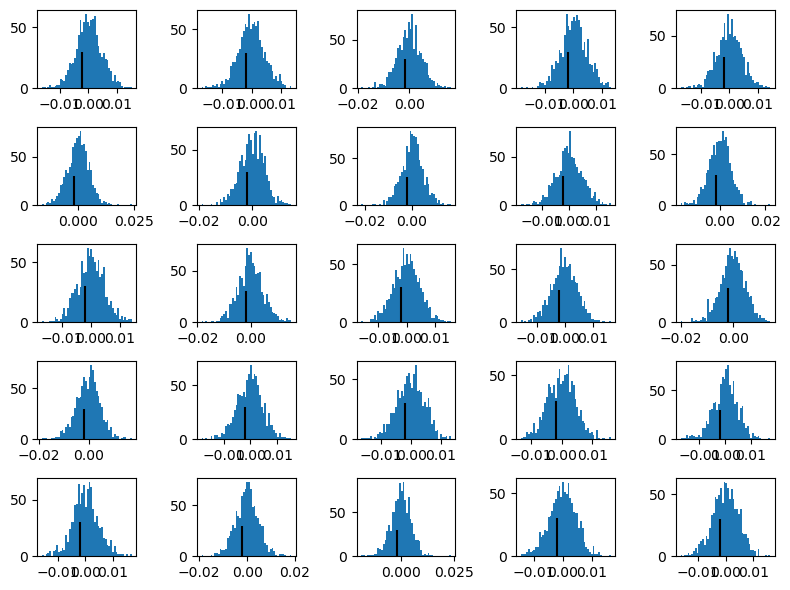

In [7]:
fig, ax = plt.subplots(5,5, figsize=(8,6),)
count = 0
for i in range(5):
    for j in range(5):
        ax[i,j].hist(stats_h0[count, :], bins=50)
        ax[i,j].vlines(x=stats[count], ymin=0, ymax=30)
        count +=1
plt.tight_layout()

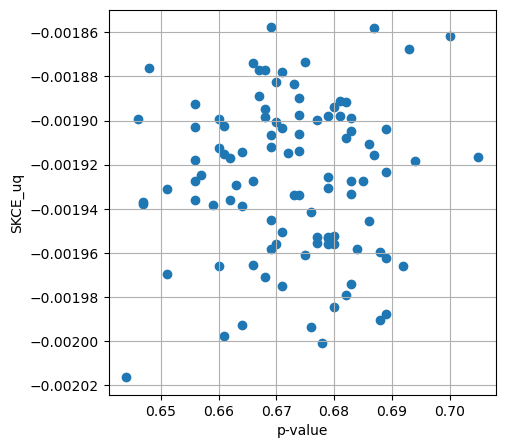

In [9]:
fig, ax = plt.subplots(figsize=(5,5))
ax.scatter(p_vals, stats)
ax.set_xlabel("p-value")
ax.set_ylabel("SKCE_uq")
plt.grid()

test for ECE:

In [11]:
p_probs, y_labels = experiment_h0(N=N_FEATURES, M=N_FEATURES, K=N_CLASSES, u=U_DIR, l_prior=10)

In [13]:
stats, stats_h0, p_vals = npbe_test_v3_p_values(p_probs=p_probs,y_labels=y_labels, params=config_p_value_analysis["SKCEul"]["params"])

100%|██████████| 100/100 [15:07<00:00,  9.07s/it]


In [15]:
p_vals

array([0.246, 0.25 , 0.226, 0.241, 0.226, 0.25 , 0.253, 0.247, 0.248,
       0.228, 0.248, 0.246, 0.256, 0.266, 0.242, 0.241, 0.236, 0.237,
       0.245, 0.257, 0.241, 0.241, 0.252, 0.216, 0.273, 0.247, 0.257,
       0.274, 0.245, 0.228, 0.228, 0.261, 0.221, 0.258, 0.238, 0.227,
       0.247, 0.27 , 0.22 , 0.236, 0.232, 0.253, 0.254, 0.263, 0.255,
       0.258, 0.227, 0.238, 0.268, 0.24 , 0.248, 0.244, 0.264, 0.24 ,
       0.265, 0.261, 0.262, 0.235, 0.268, 0.23 , 0.238, 0.247, 0.261,
       0.258, 0.258, 0.227, 0.246, 0.251, 0.239, 0.242, 0.225, 0.255,
       0.27 , 0.223, 0.273, 0.235, 0.227, 0.237, 0.257, 0.237, 0.234,
       0.237, 0.253, 0.243, 0.255, 0.242, 0.222, 0.253, 0.263, 0.265,
       0.246, 0.238, 0.241, 0.277, 0.223, 0.249, 0.25 , 0.252, 0.245,
       0.237])

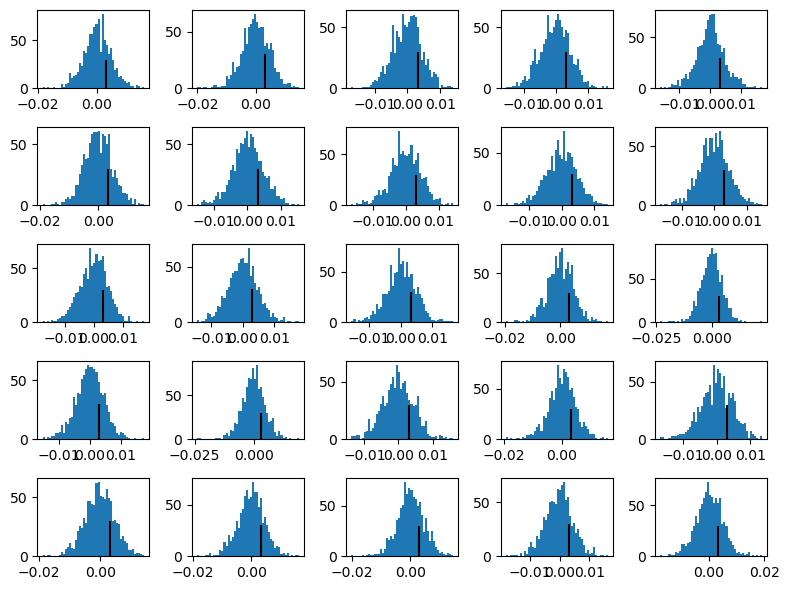

In [14]:
fig, ax = plt.subplots(5,5, figsize=(8,6),)
count = 0
for i in range(5):
    for j in range(5):
        ax[i,j].hist(stats_h0[count, :], bins=50)
        ax[i,j].vlines(x=stats[count], ymin=0, ymax=30)
        count +=1
plt.tight_layout()

### analyze distributions of miscalibration estimators

In [7]:
N_ITER = 100
min_stat, p_vals, stats = npbe_test_p_values(p_probs=p_probs, y_labels=y_labels, 
                                             params=config_p_value_analysis["SKCEul"]["params"])

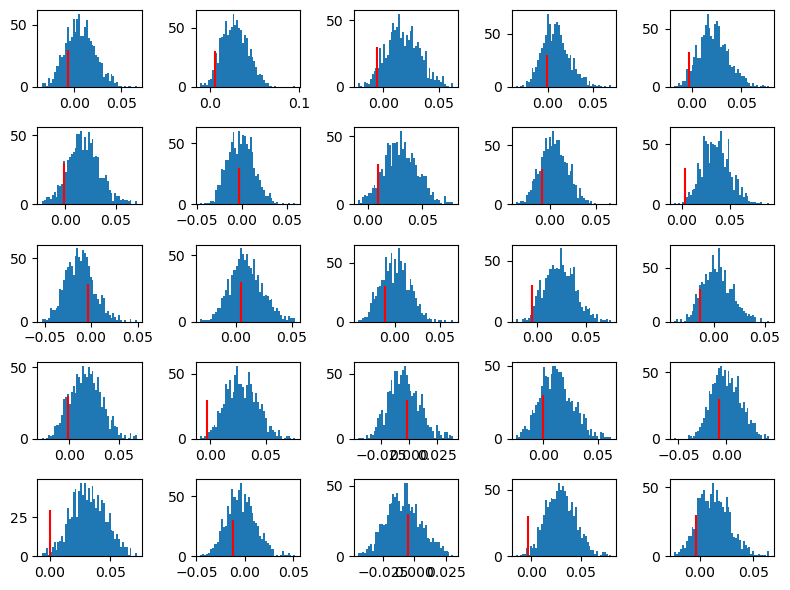

In [16]:
fig, ax = plt.subplots(5, 5, figsize=(8,6))
for i in range(5):
    for j in range(5):
        p_probs, y_labels = experiment_h0(N=100, M=10, K=10, u=0.01)
        min_stat, p_vals, stats = npbe_test_p_values(p_probs=p_probs, y_labels=y_labels,
                                                     params=config_p_value_analysis["SKCEul"]["params"])
        ax[i,j].hist(stats, bins=50)
        ax[i,j].vlines(x=min_stat, ymin=0, ymax=30, colors='r')               
plt.tight_layout()

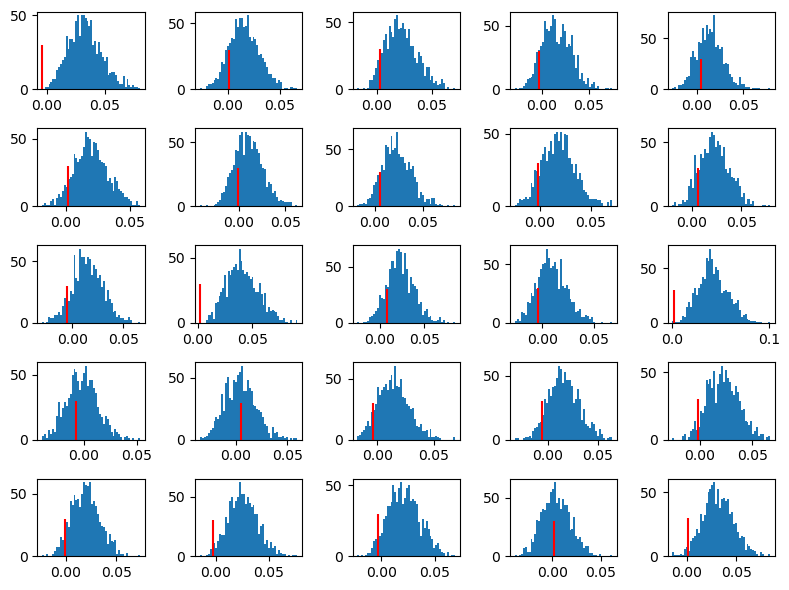

In [2]:
fig, ax = plt.subplots(5, 5, figsize=(8,6))
for i in range(5):
    for j in range(5):
        p_probs, y_labels = experiment_h0(N=100, M=10, K=10, u=0.01, l_prior=10)
        min_stat, p_vals, stats = npbe_test_p_values(p_probs=p_probs, y_labels=y_labels, params=config_p_value_analysis["SKCEul"]["params"])
        ax[i,j].hist(stats, bins=50)
        ax[i,j].vlines(x=min_stat, ymin=0, ymax=30, colors='r')
plt.tight_layout()

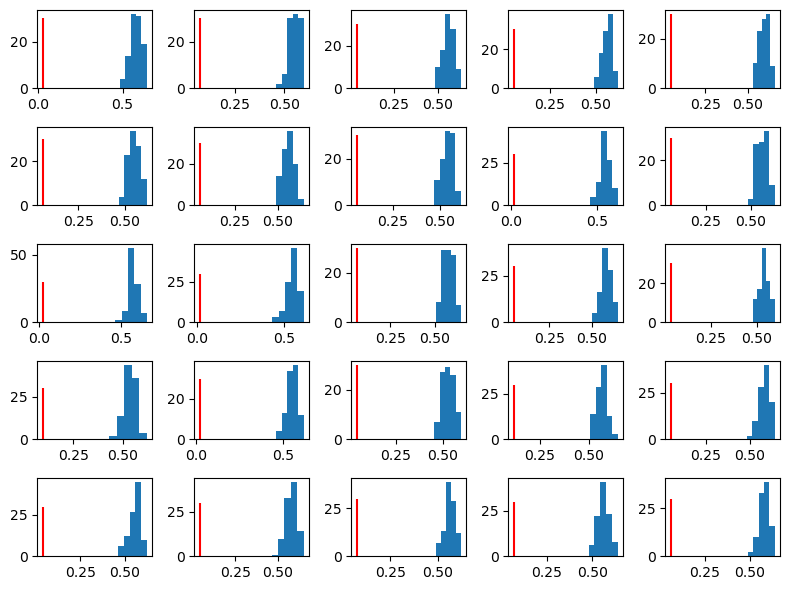

In [3]:
fig, ax = plt.subplots(5, 5, figsize=(8,6))
for i in range(5):
    for j in range(5):
        p_probs, y_labels = experiment_h0(N=100, M=10, K=10, u=0.01, l_prior=10)
        min_stat, p_vals, stats = npbe_test_p_values(p_probs=p_probs, y_labels=y_labels, params=config_p_value_analysis["ECEconf5"]["params"])
        ax[i,j].hist(stats, bins=5)
        ax[i,j].vlines(x=min_stat, ymin=0, ymax=30, colors='r')
plt.tight_layout()

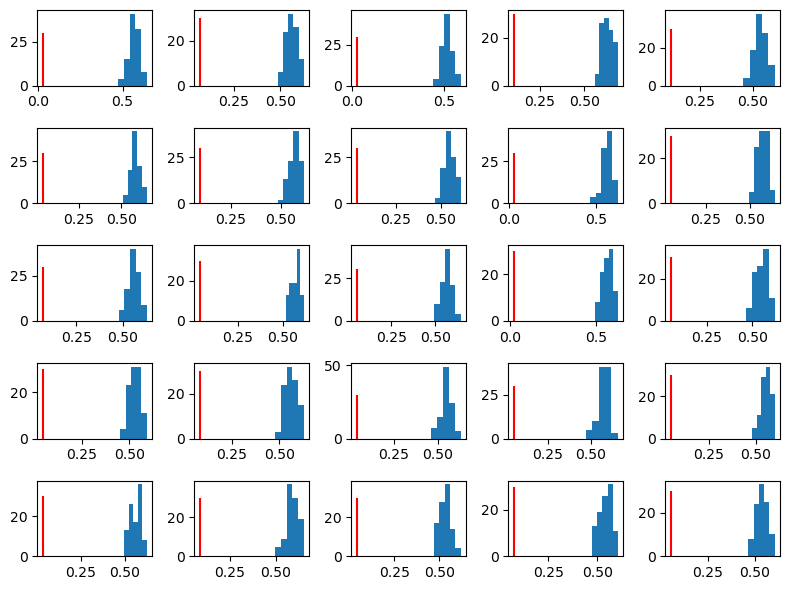

In [3]:
fig, ax = plt.subplots(5, 5, figsize=(8,6))
for i in range(5):
    for j in range(5):
        p_probs, y_labels = experiment_h0(N=100, M=10, K=10, u=0.01, l_prior=10)
        min_stat, p_vals, stats = npbe_test_p_values(p_probs=p_probs, y_labels=y_labels, params=config_p_value_analysis["ECEconf5"]["params"])
        ax[i,j].hist(stats, bins=5)
        ax[i,j].vlines(x=min_stat, ymin=0, ymax=30, colors='r')
plt.tight_layout()

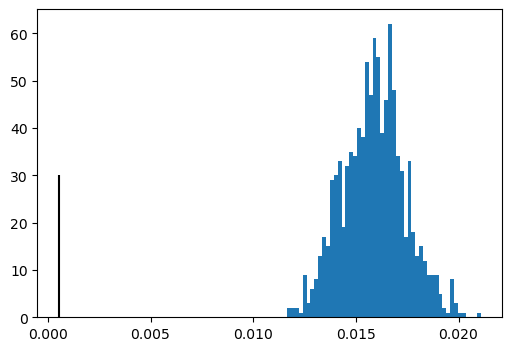

In [3]:
min_stat, p_vals, stats = npbe_test_p_values(p_probs=p_probs, y_labels=y_labels, params=config_p_value_analysis["SKCEuq"]["params"])

fig, ax = plt.subplots(figsize=(6,4))
ax.hist(stats, bins=50)
ax.vlines(x=min_stat, ymin=0, ymax=30)

### p-value Analysis to visualize correlation between p-value and value of statistic

In [2]:
result_skceuq = _simulation_pvals(tests=config_p_value_analysis, N=100, M=10, K=10, R=5, u=0.01, experiment=experiment_h0)

  0%|          | 0/5 [00:00<?, ?it/s]/Users/mirajuergens/Library/CloudStorage/OneDrive-UGent/Code/EnsembleCalibration/ensemblecalibration/calibration/calibration_estimates/hl.py:60: RuntimeWarning: divide by zero encountered in double_scalars
  dev_bk = ((o_bk-p_bk)**2)/p_bk
/Users/mirajuergens/Library/CloudStorage/OneDrive-UGent/Code/EnsembleCalibration/ensemblecalibration/calibration/calibration_estimates/hl.py:60: RuntimeWarning: invalid value encountered in double_scalars
  dev_bk = ((o_bk-p_bk)**2)/p_bk
100%|██████████| 5/5 [11:18<00:00, 135.67s/it]


In [5]:
result_skceuq

{'SKCEul': array([[ 8.83750422e-03,  2.84251385e-03,  7.49812738e-03,
          8.79483859e-04, -9.53990947e-03],
        [ 4.26000000e-01,  9.68000000e-01,  6.36000000e-01,
          9.20000000e-01,  8.43000000e-01]]),
 'HL5': array([[22.3566091 , 37.91172056, 27.28180728, 16.19859839, 21.80542646],
        [ 1.        ,  1.        ,  1.        ,  1.        ,  1.        ]]),
 'HL10': array([[37.70746078, 58.83520921, 47.27653128, 31.86675393, 47.1253145 ],
        [ 1.        ,  1.        ,  1.        ,  1.        ,  1.        ]]),
 'ECEconf5': array([[0.01707399, 0.06912498, 0.07252361, 0.0672907 , 0.03688081],
        [1.        , 1.        , 1.        , 1.        , 1.        ]]),
 'ECEconf10': array([[0.02484596, 0.08136251, 0.08355506, 0.11684673, 0.05215653],
        [1.        , 1.        , 1.        , 1.        , 1.        ]]),
 'ECEclass5': array([[0.03359214, 0.04055606, 0.03441673, 0.03739249, 0.04431871],
        [1.        , 1.        , 1.        , 1.        , 1.        ]]

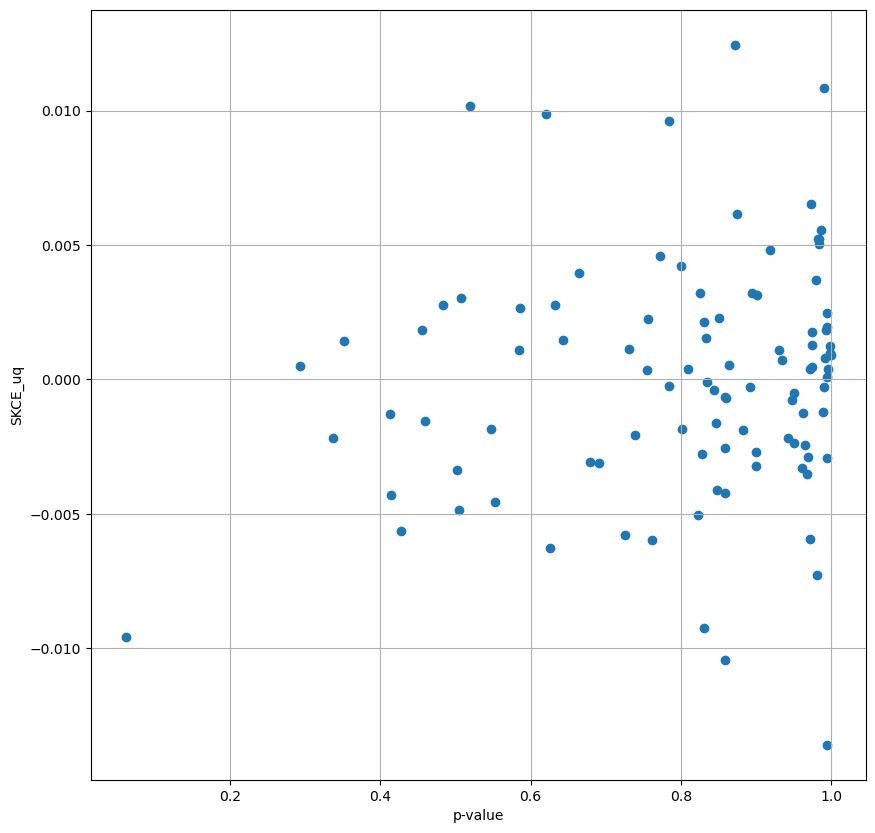

In [47]:
fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(result_skceuq[0]["SKCEul"][1, :], result_skceuq[0]["SKCEul"][0, :])
ax.set_xlabel("p-value")
ax.set_ylabel("SKCE_uq")
plt.grid()

